## Physics Informed Neural Networks to Approximate Solution of PDEs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)
import os

In [2]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_
        # @AmrUmeri: Added constants
        self.alpha_f = 0.05
        self.alpha_s = 0.08
        self.h_f = 5
        self.h_s = 6
        self.T_hot = 4
        self.T_zero = 1
        self.u_f = 1

        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        # @AmrUmeri: Modified time and space dimension
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # F Dense NN to approximate the solution of the underlying heat equation
        # @AmrUmeri: Initialized approximate neural network solution
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=2,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              retrain_seed=42)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    # @AmrUmeri: Modified initial condition
    def initial_condition(self):
        return self.T_zero


    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        
        # @AmrUmeri: Added temporal boundary condition for both phases, fluid and solid
        output_tb = torch.zeros(self.n_tb, 2).fill_(self.initial_condition())
    
        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 2))
        output_sb_L = torch.zeros((input_sb.shape[0], 2))
        
        # @AmrUmeri: Added spatial boundary condition for both phases, fluid and solid
        output_sb_0 = ((self.T_hot-self.T_zero)/(1+torch.exp(-200*(input_sb[:, 0]-0.25)))+self.T_zero).reshape(-1,1)
        zero_entry_tensor = torch.zeros_like(output_sb_0)
        output_sb_0 = torch.cat((output_sb_0, zero_entry_tensor), dim=1)

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        # @AmrUmeri: Added requires_grad to allow computation of gradient
        input_sb.requires_grad = True
        
        # @AmrUmeri: Apply spatial boundary conditions
        input_sb_x0 = input_sb[0:int(input_sb.shape[0]/2), :]
        input_sb_xL = input_sb[int(input_sb.shape[0]/2):int(input_sb.shape[0])+1, :]
    
        u_pred_Tf_x0 = self.approximate_solution(input_sb_x0)[:, 0]
        u_pred_Ts_x0 = self.approximate_solution(input_sb_x0)[:, 1]
        
        # @AmrUmeri: 
        grad_Ts_x0 = torch.autograd.grad(u_pred_Ts_x0.sum(), input_sb_x0, create_graph=True)[0][:, 1]
        
        u_pred_Tf_xL = self.approximate_solution(input_sb_xL)[:, 0]
        u_pred_Ts_xL = self.approximate_solution(input_sb_xL)[:, 1]
        
        grad_Tf_xL = torch.autograd.grad(u_pred_Tf_xL.sum(), input_sb_xL, create_graph=True)[0][:, 1]
        grad_Ts_xL = torch.autograd.grad(u_pred_Ts_xL.sum(), input_sb_xL, create_graph=True)[0][:, 1]
        
        u_pred_1 = torch.cat((u_pred_Tf_x0.reshape(-1,1), grad_Ts_x0.reshape(-1,1)), dim = 1)
        u_pred_2 = torch.cat((grad_Tf_xL.reshape(-1,1), grad_Ts_xL.reshape(-1,1)), dim = 1)

        return torch.cat((u_pred_1, u_pred_2), dim = 0)

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)
        T_f = u[:,0]
        T_s = u[:,1]
        
        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 + u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2], [dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_tf = torch.autograd.grad(T_f.sum(), input_int, create_graph=True)[0]
        grad_ts = torch.autograd.grad(T_s.sum(), input_int, create_graph=True)[0]
        
        grad_ts_t = grad_ts[:,0] 
        grad_ts_x = grad_ts[:,1]
        grad_tf_t = grad_tf[:,0]
        grad_tf_x = grad_tf[:,1 ]
        
        grad_tf_xx = torch.autograd.grad(grad_tf_x.sum(), input_int, create_graph=True)[0][:,1]
        grad_ts_xx = torch.autograd.grad(grad_ts_x.sum(), input_int, create_graph=True)[0][:,1]


        residual_1 = (grad_tf_t) + (self.u_f*grad_tf_x) - (self.alpha_f*grad_tf_xx) + (self.h_f*(T_f - T_s))
        residual_2 = (grad_ts_t) - (self.alpha_s*grad_ts_xx) - self.h_s*(T_f - T_s)
        
        return residual_1.reshape(-1, ), residual_2.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])


        r_1, r_2 = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb
        
        
        Tf_train_sb_0 = u_train_sb[0:int(u_train_sb.shape[0]/2), 0]
        Tf_pred_sb_0 = u_pred_sb[0:int(u_train_sb.shape[0]/2), 0]
        res_Tf_sb_0 = Tf_train_sb_0 - Tf_pred_sb_0

        Tf_train_sb_L = u_train_sb[int(u_train_sb.shape[0]/2):int(u_train_sb.shape[0])+1, 0]
        Tf_pred_sb_L = u_pred_sb[int(u_train_sb.shape[0]/2):int(u_train_sb.shape[0])+1, 0]
        res_Tf_sb_L = Tf_train_sb_L - Tf_pred_sb_L
        
        Ts_train_sb_0 = u_train_sb[0:int(u_train_sb.shape[0]/2), 1]
        Ts_pred_sb_0 = u_pred_sb[0:int(u_train_sb.shape[0]/2), 1]
        res_Ts_sb_0 = Ts_train_sb_0 - Ts_pred_sb_0
        
        Ts_train_sb_L = u_train_sb[int(u_train_sb.shape[0]/2):int(u_train_sb.shape[0])+1, 1]
        Ts_pred_sb_L = u_pred_sb[int(u_train_sb.shape[0]/2):int(u_train_sb.shape[0])+1, 1]
        res_Ts_sb_L = Ts_train_sb_L - Ts_pred_sb_L
    
        

        loss_sb = torch.mean(abs(res_Tf_sb_0)**2)+torch.mean(abs(res_Ts_sb_0)**2)+torch.mean(abs(res_Ts_sb_L)**2)+torch.mean(abs(res_Tf_sb_L) ** 2)
        loss_tb = torch.mean(abs(r_tb)**2)
        loss_int = torch.mean(abs(r_1)**2)+torch.mean(abs(r_2)**2)

        loss_u = loss_sb + loss_tb

        loss = torch.log10(self.lambda_u * (1*loss_sb + 1*loss_tb) + 1*loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs)
        output_Tf = output[:,0].reshape(-1,)
        output_Ts = output[:,1].reshape(-1,)

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c = output_Tf.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c = output_Ts.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Approximate Solution $T_f$")
        axs[1].set_title("Approximate Solution $T_s$")
        
        plt.show()
        
        return fig



In [3]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

In [4]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))

################################  0  ################################
Total loss:  2.3624 | PDE Loss:  1.1527 | Function Loss:  1.9457
Total loss:  2.3071 | PDE Loss:  1.1268 | Function Loss:  1.8382
Total loss:  2.1081 | PDE Loss:  0.911 | Function Loss:  1.6701
Total loss:  1.9951 | PDE Loss:  0.8484 | Function Loss:  1.4523
Total loss:  1.8096 | PDE Loss:  0.7492 | Function Loss:  0.923
Total loss:  1.7431 | PDE Loss:  0.7111 | Function Loss:  0.5944
Total loss:  1.7064 | PDE Loss:  0.6671 | Function Loss:  0.6438
Total loss:  1.5212 | PDE Loss:  0.2946 | Function Loss:  1.1304
Total loss:  1.4731 | PDE Loss:  0.288 | Function Loss:  1.0133
Total loss:  1.4377 | PDE Loss:  0.2781 | Function Loss:  0.9255
Total loss:  1.4281 | PDE Loss:  0.2721 | Function Loss:  0.9077
Total loss:  1.414 | PDE Loss:  0.2567 | Function Loss:  0.8968
Total loss:  1.385 | PDE Loss:  0.2168 | Function Loss:  0.8916
Total loss:  1.3576 | PDE Loss:  0.1723 | Function Loss:  0.8985
Total loss:  1.3273 | PDE

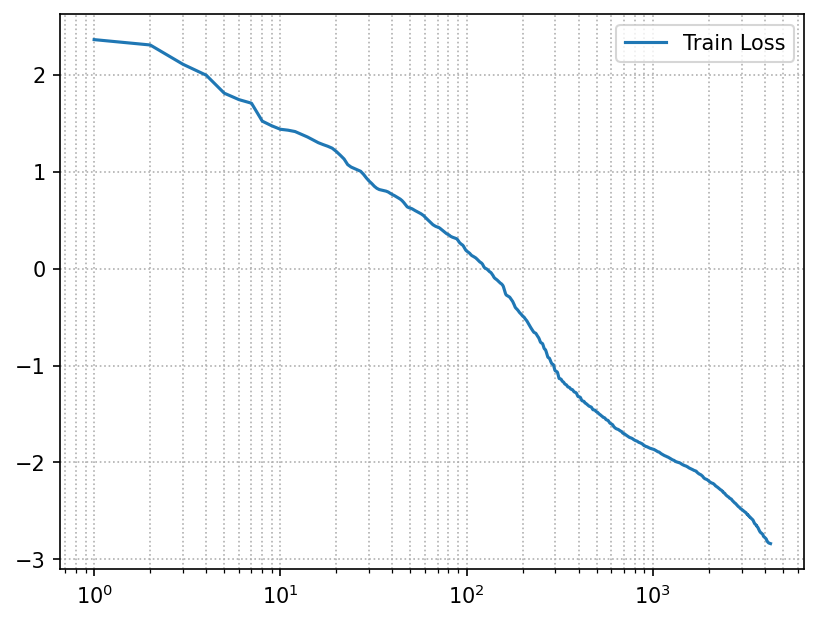

In [5]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

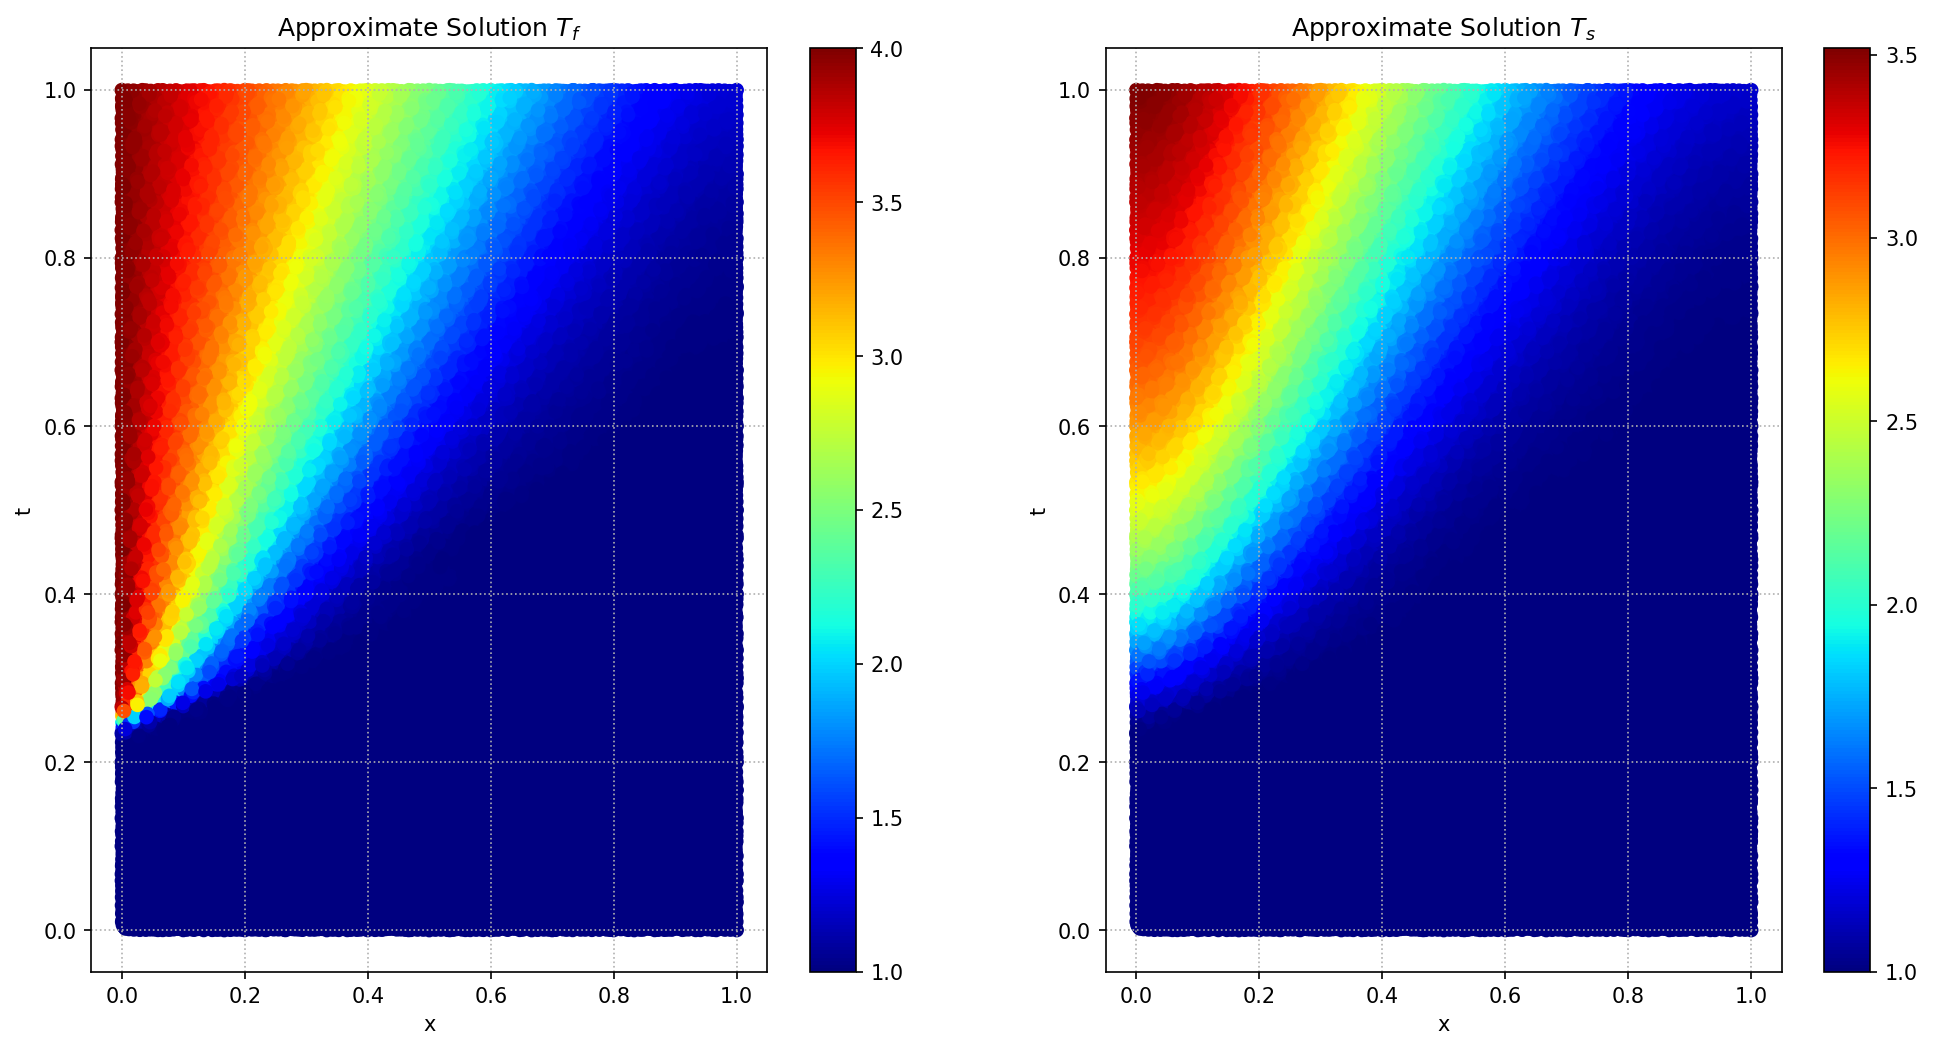

In [6]:
figex = pinn.plotting()
figex.savefig("./Task1_Approximate_Solution.png")

In [8]:

testing_data = pd.read_csv("Proj1_Y24/Task1/TestingData.txt", delimiter=',')

t_testing = torch.tensor(testing_data['t'].values, dtype=torch.float32).reshape(-1, 1)
x_testing = torch.tensor(testing_data['x'].values, dtype=torch.float32).reshape(-1, 1)

testing_data_tensor = torch.tensor(testing_data.values, dtype=torch.float32)

In [13]:
prediction_testing_data = pinn.approximate_solution(testing_data_tensor)
test_prediction = testing_data.copy()
test_prediction['tf'] = prediction_testing_data[:, 0].detach().numpy()
test_prediction['ts'] = prediction_testing_data[:, 1].detach().numpy()

test_prediction.to_csv("Task1.txt", header=True, index=None, sep=',', mode='w')

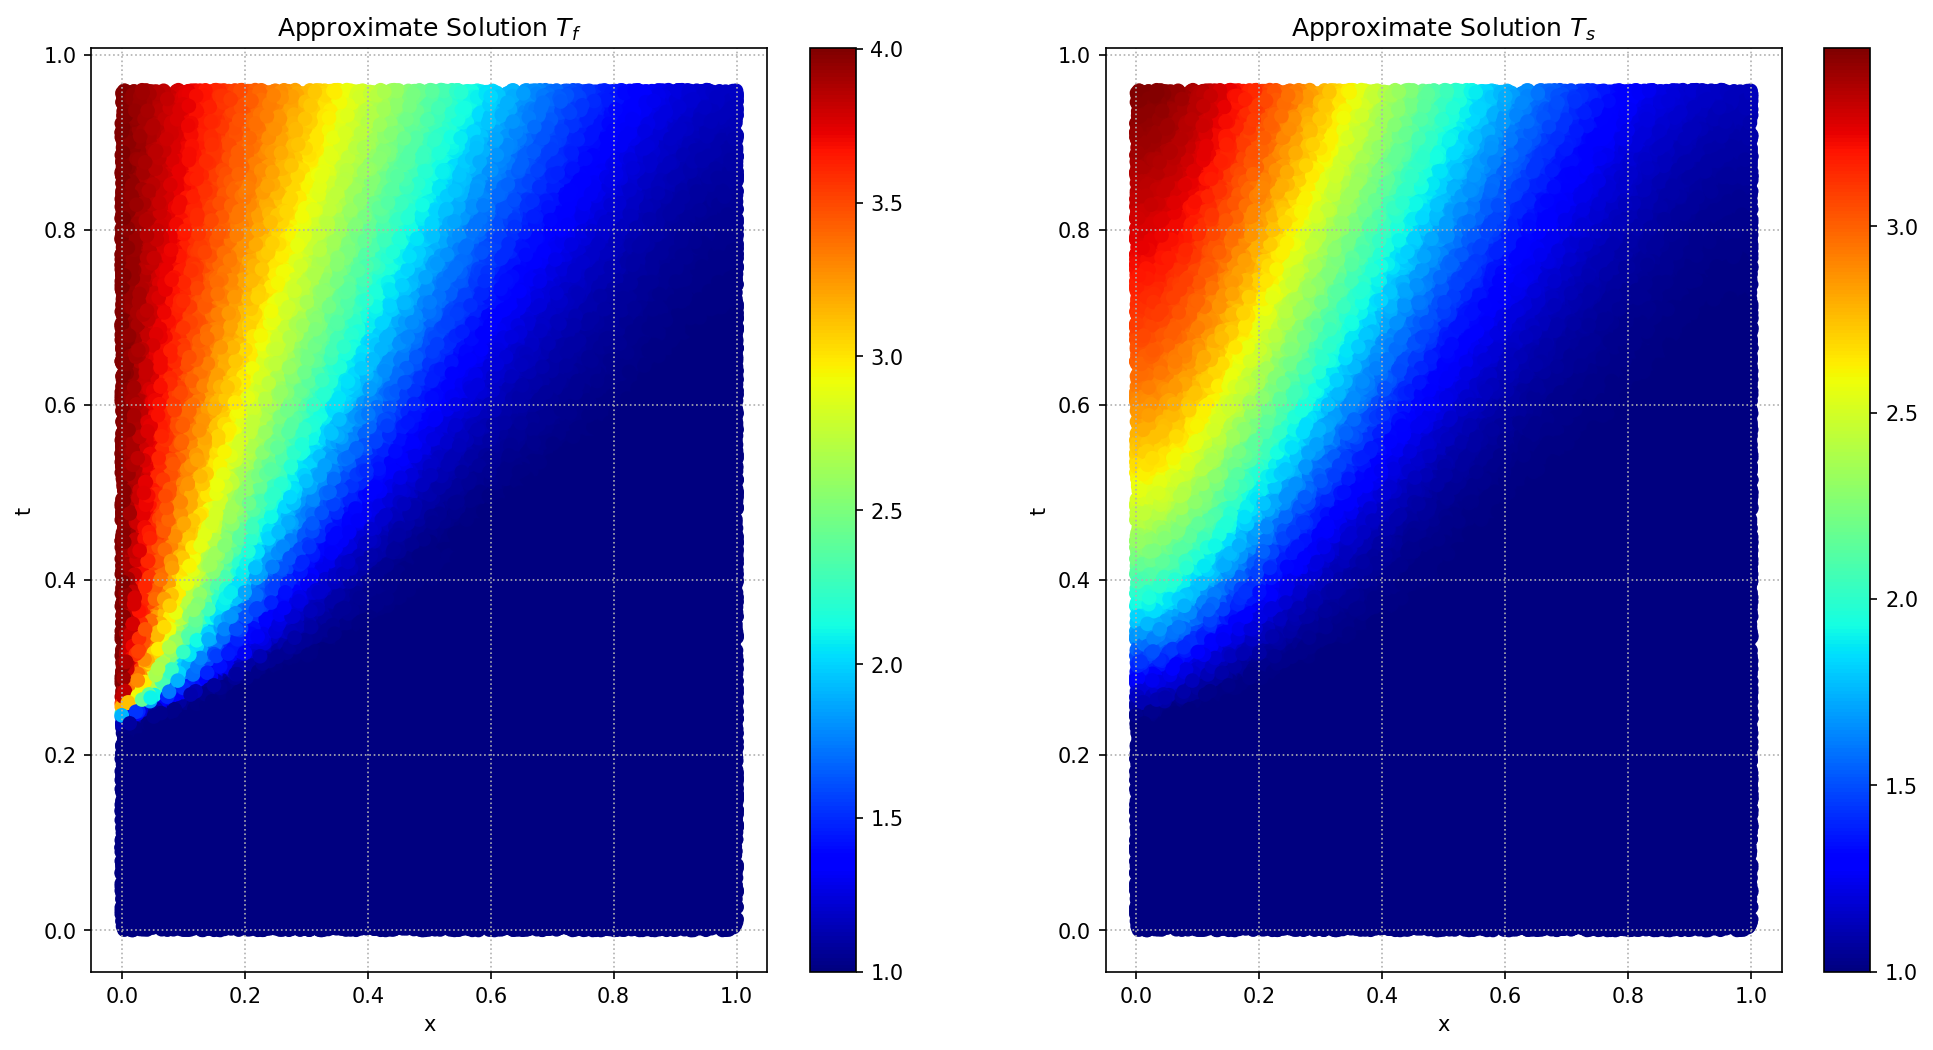

In [17]:
output = pinn.approximate_solution(testing_data_tensor)
output_Tf = output[:, 0].reshape(-1, )
output_Ts = output[:, 1].reshape(-1, )

fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(testing_data_tensor[:, 1].detach(), testing_data_tensor[:, 0].detach(), c=output_Tf.detach(), cmap="jet")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(testing_data_tensor[:, 1].detach(), testing_data_tensor[:, 0].detach(), c=output_Ts.detach(), cmap="jet")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[0].set_title("Approximate Solution $T_f$")
axs[1].set_title("Approximate Solution $T_s$")
plt.savefig("./Task1_Prediction_Solution.png")
plt.show()

